In [23]:
import pandas as pd
import torch
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from transformers import DistilBertForSequenceClassification
import torch
from tqdm import tqdm
from pickle import load
from sklearn.metrics import confusion_matrix

In [24]:
device = "cuda"

In [25]:
# load data form parquet
data = pd.read_parquet("../../training/datasets/chat_gpt_annotated_data.parquet")
data.head()

,text,label,spans,article_id,sentence_id
0,Is there a case for a basic income guarantee –...,universal_basic_income,[],1520,0
1,I outline a coherent adjustment framework to a...,universal_basic_income,[],1520,1
2,Adopting a basic income guarantee in this cont...,universal_basic_income,[],1520,2
3,Just Transition Framework\nThe Just Transition...,universal_basic_income,[],1520,3
4,][Reference: (1996) ‘Sustainable development: ...,universal_basic_income,[],1520,4


In [26]:
model = DistilBertForSequenceClassification.from_pretrained(
            "2024-02-02-distilbert-base-uncased/seed_1", 
            local_files_only=True
).to(device)
tokenizer = AutoTokenizer.from_pretrained(f"./2024-02-02-distilbert-base-uncased", local_files_only=True)
le = load(open(f'2024-02-02-distilbert-base-uncased/label_encoder.pkl', 'rb'))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [27]:
predictions = []
for idx, row in tqdm(data.iterrows(), total=len(data)):
    encoded_text = tokenizer(
    row.text,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=512
    )
    encoded_text = encoded_text.to(device)
    output = model(**encoded_text, output_attentions=False, output_hidden_states=False)
    class_probs = torch.nn.Softmax(dim=1)(output.logits)
    prediction = torch.argmax(class_probs, dim=1)
    predictions.append(prediction)

100%|██████████| 18750/18750 [02:30<00:00, 124.29it/s]


In [28]:
predictions = [le.inverse_transform([x.item()])[0] for x in predictions]
data["predictions"] = predictions

<Axes: >

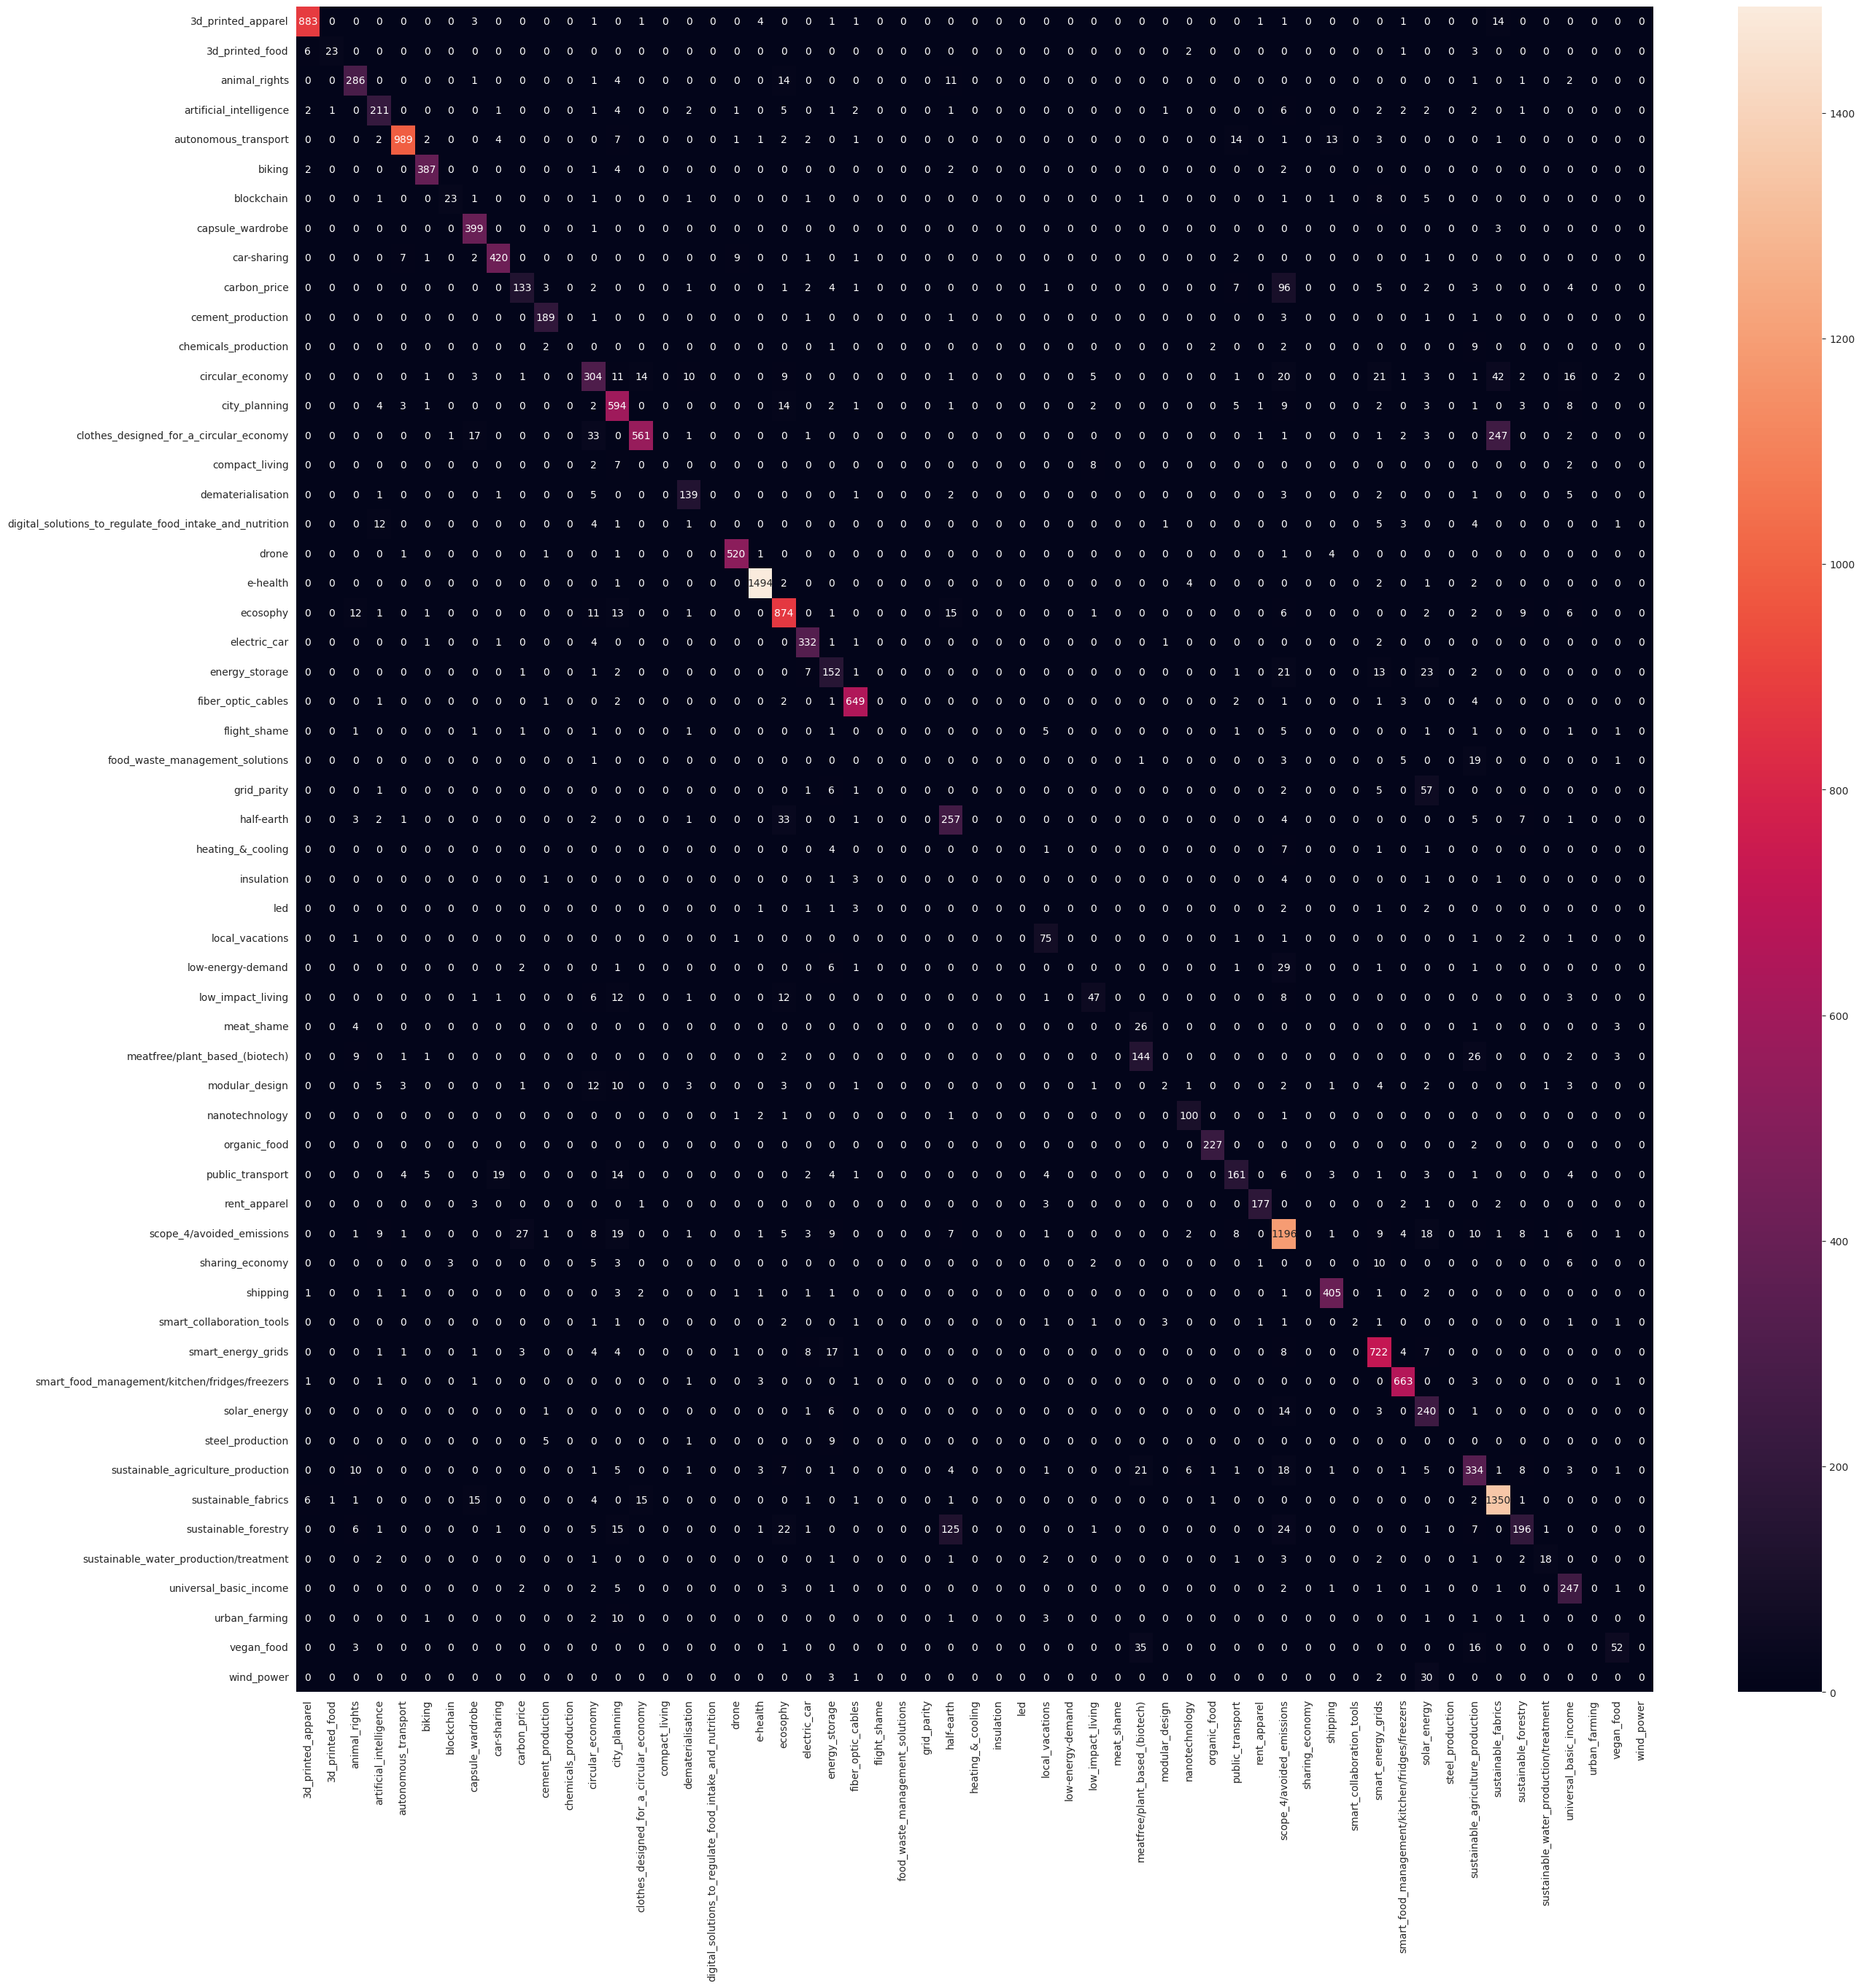

In [33]:
plt.figure(figsize=(30, 30))
# create confusion matrix with the predictions the labels (sklearn)
cm  = confusion_matrix(data["label"], data["predictions"], labels=le.classes_)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_)

In [37]:
true_labels = data['label'].unique()
predicted_labels = data['predictions'].unique()
missing_labels = set(true_labels) - set(predicted_labels)
print("Labels with no predictions:", missing_labels)

Labels with no predictions: {'urban_farming', 'low-energy-demand', 'chemicals_production', 'meat_shame', 'heating_&_cooling', 'food_waste_management_solutions', 'digital_solutions_to_regulate_food_intake_and_nutrition', 'led', 'wind_power', 'flight_shame', 'grid_parity', 'sharing_economy', 'steel_production', 'insulation', 'compact_living'}


In [48]:
# compute per class accuracy, precision, recall and f1 (get a summary)
from sklearn.metrics import classification_report
performance = classification_report(data["label"], data["predictions"], target_names=le.classes_, zero_division=0.0, output_dict=True)
# print performance by descending f1
performance = pd.DataFrame(performance)
performance.T

,precision,recall,f1-score,support
3d_printed_apparel,0.980022,0.969265,0.974614,911.000000
3d_printed_food,0.920000,0.657143,0.766667,35.000000
animal_rights,0.848665,0.890966,0.869301,321.000000
artificial_intelligence,0.824219,0.850806,0.837302,248.000000
autonomous_transport,0.977273,0.948226,0.962530,1043.000000
biking,0.965087,0.972362,0.968711,398.000000
blockchain,0.851852,0.522727,0.647887,44.000000
capsule_wardrobe,0.890625,0.990074,0.937720,403.000000
car-sharing,0.937500,0.945946,0.941704,444.000000
carbon_price,0.777778,0.501887,0.610092,265.000000
